In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import re, string

import time

In [2]:
!ls

Classification.ipynb		 classification_tiny.ipynb
classification_tiny-Copy1.ipynb  Topic_modelling.ipynb


In [3]:
#punctuation = list(string.punctuation)

my_stopwords = nltk.corpus.stopwords.words('english')# punctuation

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def tokenize(s):
    output = re.sub(r'\d+', '', s) # remove numbers 
    output = remove_links(output)
    result = re_tok.sub(r' \1 ', output).split() 
    result = [word for word in result if len(word)>2]
    result = [word for word in result if word not in my_stopwords]
    return result

xtrain shape (8089, 40659)
xtest shape (2023, 40659)
In PCA
xtrain pca shape (8089, 6000)
explained variance: 0.9698449741268098
target counts:
 open      7921
closed     168
Name: OpenStatus, dtype: int64
time elapsed: 18.797316551208496
preds unique: ['closed' 'open']
Fold: 0
Accuracy=0.9634206623826


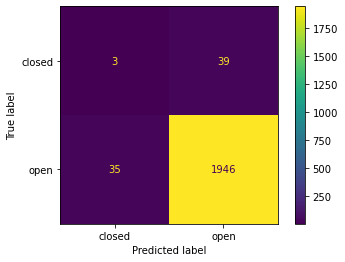

In [5]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

if __name__=="__main__":
    
    df = pd.read_csv("../input/train_tiny_folds.csv")
    
    for fold_ in range(1):
        train_df = df[df.kfold != fold_].reset_index(drop = True)
        test_df = df[df.kfold == fold_].reset_index(drop = True)
    
        vectorizer = TfidfVectorizer(tokenizer = tokenize,
                                     token_pattern=None)
        # fit TFIDF
        xtrain = vectorizer.fit(train_df.BodyMarkdown)
        # transform
        xtrain = vectorizer.transform(train_df.BodyMarkdown)
        xtest = vectorizer.transform(test_df.BodyMarkdown)
        
        print('xtrain shape', xtrain.shape)
        print('xtest shape', xtest.shape)
        # perform PCA
        svd = TruncatedSVD(n_components=6000, n_iter=7, random_state=42)
        print('In PCA')
        svd.fit(xtrain)
        xtrain = svd.transform(xtrain)
        xtest = svd.transform(xtest)
        print('xtrain pca shape', xtrain.shape)
        print('explained variance:', svd.explained_variance_ratio_.sum())
        # target
        ytrain = train_df.OpenStatus
        ytest = test_df.OpenStatus
        print('target counts:\n', train_df.OpenStatus.value_counts())
        #model
        model = linear_model.LogisticRegression(max_iter=5000,class_weight='balanced',
                                                n_jobs=-1
                                               )
        
        to=time.time()
        # fit the model
        model.fit(xtrain,train_df.OpenStatus)
        
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-to
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold: {fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")
        

### use embeddings

In [6]:
import numpy as np
def sentence_to_vec(s,embedding_dict,stop_words,tokenizer):
    """
    s: sentence, string
    embedding_dict: dictionary word: vector
    stop_words: list of stop words
    tokenizer: tokenizer function
    """
    # convert sentence to string and lowercase it
   # words = str(s).lower()
    # tokenize the sentence
    words = s
    words = tokenizer(words)
    # remove stop words
   # words =[w for w in words if not w in stop_words]
    
    # keep only alpha numeric tokens
    words =[w for w in words if w.isalpha()]
    # initialize empty list to store embeddings
    M = []
    for w in words:
        # for every word, get the embedding from the dictionary
        # and append to the list of embeddings
        if w in embedding_dict:
            M.append(embedding_dict[w])
        # if we don't have any vectors return zeros
    if len(M)==0:
        return np.zeros(300)
    # convert list of embeddings to array
    M = np.array(M)
    # calculate sum over axis=0
    v = M.sum(axis=0)
    return v/np.sqrt((v**2).sum())       

In [7]:
import io
def load_vectors(fname):
    fin = io.open(fname,'r',
                  encoding ='utf-8',
                  newline = '\n',
                  errors='ignore'
                 )
    n,d = map(int,fin.readline().split())
    data ={}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]]=list(map(float,tokens[1:]))
    return data    

In [8]:
!ls

Classification.ipynb		 classification_tiny.ipynb
classification_tiny-Copy1.ipynb  Topic_modelling.ipynb


In [9]:
print("Loading embeddings")
embeddings = load_vectors("../input/crawl-300d-2M.vec")

Loading embeddings


In [27]:
#embeddings=[]

In [10]:
df = pd.read_csv("../input/train_tiny_folds.csv")

In [11]:
df.head(3)

,Title,BodyMarkdown,OpenStatus,kfold
0,How to set a font to LabelField text in Blackb...,i don't know how to apply font style to a text...,open,0
1,Blend multiple jQuery files - Best practice?,I'm starting to learn JavaScript and jQuery. I...,open,0
2,stored procedure calling data in a different s...,"SQL 2008 R2:\r\nNormally, we create our table,...",open,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         10112 non-null  object
 1   BodyMarkdown  10112 non-null  object
 2   OpenStatus    10112 non-null  object
 3   kfold         10112 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 316.1+ KB


creating sentence embedding
the BodyMarkDown column embedding
1st column shape (10112, 300)
the Title column embedding
2nd column shape (10112, 300)
Train column shape (10112, 600)
time embedding 8.599654197692871
training fold: {fold_}
xtrain shape (8089, 600)
time elapsed: 3.6234312057495117
preds unique: ['closed' 'open']
Fold:0
Accuracy=0.8764211566979733


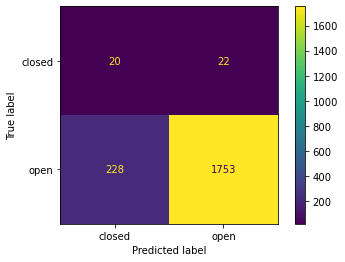

 
training fold: {fold_}
xtrain shape (8089, 600)
time elapsed: 3.1968231201171875
preds unique: ['closed' 'open']
Fold:1
Accuracy=0.8521997034107761


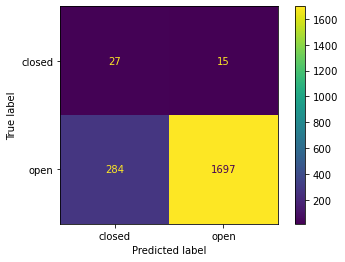

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 2.9094669818878174
preds unique: ['closed' 'open']
Fold:2
Accuracy=0.8654797230464887


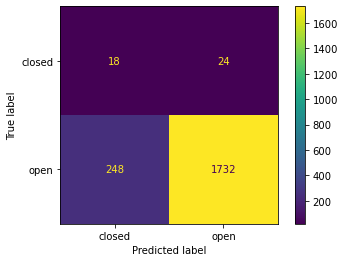

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 3.582409620285034
preds unique: ['closed' 'open']
Fold:3
Accuracy=0.8491592482690405


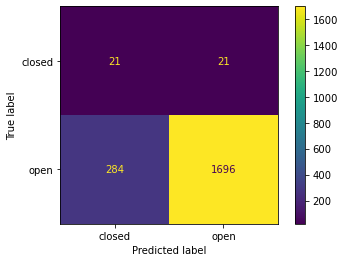

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 2.9517393112182617
preds unique: ['closed' 'open']
Fold:4
Accuracy=0.8674579624134521


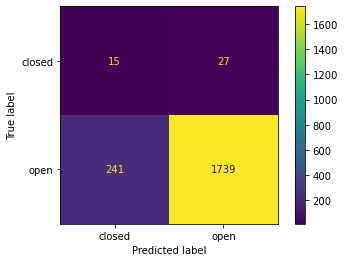

In [16]:
#create sentence embeddings
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def get_vectors(vectors,column):
    """
    vectors: empty array to fill in
    column: dataframe column
    return embedding vestors
    """
    for body in column:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    return vectors   


if __name__=="__main__":
    
    t0=time.time()
    print("creating sentence embedding")
    vector1 =[]
    vector2 =[]
    vectors=[]
    print("the BodyMarkDown column embedding")
    vector1 = get_vectors(vector1,df.BodyMarkdown.values)
    vector1 = np.array(vector1)    
    print("1st column shape",vector1.shape)
    
    print("the Title column embedding")
    vector2 = get_vectors(vector2,df.Title.values)
    vector2 = np.array(vectors2)    
    print("2nd column shape",vector2.shape)
    
    vectors = np.concatenate((vector1,vector2),axis=1)
    
    print("Train column shape",vectors.shape)
    
    # clear up memory
    vector1 =[]
    vector2 =[]
    
    t1=time.time()
    total_time = t1-t0
    print("time embedding",total_time)
               
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print("training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        
        xtest=vectors[v_,:]
        ytest =y[v_]
        model=linear_model.LogisticRegression(max_iter=5000,
                                              class_weight='balanced',
                                              n_jobs=-1)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")

### Random Forest

creating sentence embedding
the BodyMarkDown column embedding
1st column shape (10112, 300)
the Title column embedding
2nd column shape (10112, 300)
Train column shape (10112, 600)
time embedding 9.247156620025635
training fold: {fold_}
xtrain shape (8089, 600)
time elapsed: 1.3406593799591064
preds unique: ['open']
Fold:0
Accuracy=0.9792387543252595


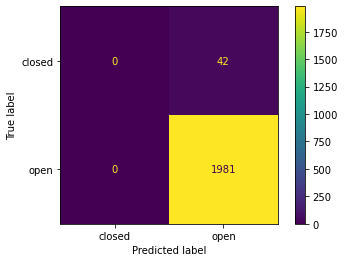

 
training fold: {fold_}
xtrain shape (8089, 600)
time elapsed: 1.3665897846221924
preds unique: ['open']
Fold:1
Accuracy=0.9792387543252595


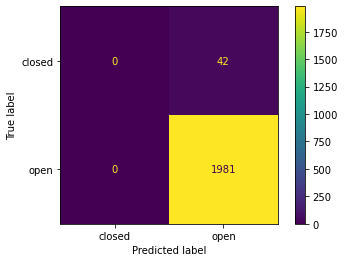

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 1.353114128112793
preds unique: ['open']
Fold:2
Accuracy=0.9792284866468842


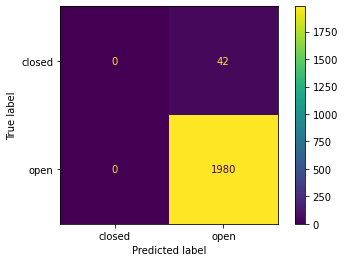

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 1.3546888828277588
preds unique: ['open']
Fold:3
Accuracy=0.9792284866468842


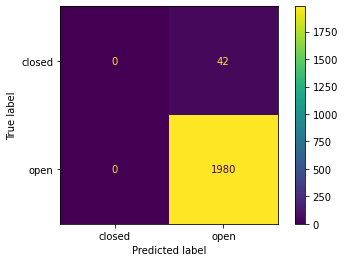

 
training fold: {fold_}
xtrain shape (8090, 600)
time elapsed: 1.3527705669403076
preds unique: ['open']
Fold:4
Accuracy=0.9792284866468842


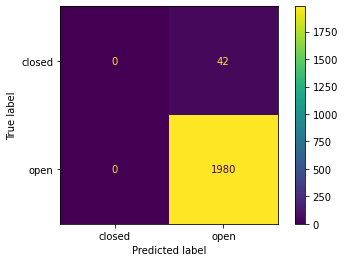

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
#create sentence embeddings
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def get_vectors(vectors,column):
    """
    vectors: empty array to fill in
    column: dataframe column
    return embedding vestors
    """
    for body in column:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    return vectors   


if __name__=="__main__":
    
    t0=time.time()
    print("creating sentence embedding")
    vector1 =[]
    vector2 =[]
    vectors=[]
    print("the BodyMarkDown column embedding")
    vector1 = get_vectors(vector1,df.BodyMarkdown.values)
    vector1 = np.array(vector1)    
    print("1st column shape",vector1.shape)
    
    print("the Title column embedding")
    vector2 = get_vectors(vector2,df.Title.values)
    vector2 = np.array(vectors2)    
    print("2nd column shape",vector2.shape)
    
    vectors = np.concatenate((vector1,vector2),axis=1)
    
    print("Train column shape",vectors.shape)
    
    # clear up memory
    vector1 =[]
    vector2 =[]
    
    t1=time.time()
    total_time = t1-t0
    print("time embedding",total_time)
               
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print("training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        
        xtest=vectors[v_,:]
        ytest =y[v_]

        model=RandomForestClassifier(n_estimators =100, 
                                     max_features='sqrt',random_state=0,
                                     max_depth=10,n_jobs=-1)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")

creating sentence embedding
the BodyMarkDown column embedding
1st column shape (10112, 300)
the Title column embedding
2nd column shape (10112, 300)
Train column shape (10112, 600)
time embedding 8.71230435371399
 
training fold: 0
xtrain shape (8089, 600)
time elapsed: 1.341486930847168
preds unique: ['open']
Fold:0
Accuracy=0.9792387543252595


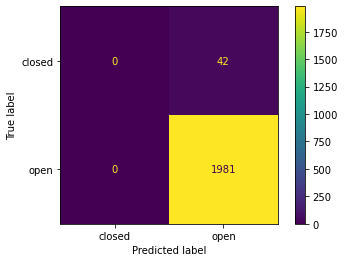

 
training fold: 1
xtrain shape (8089, 600)
time elapsed: 1.3534166812896729
preds unique: ['open']
Fold:1
Accuracy=0.9792387543252595


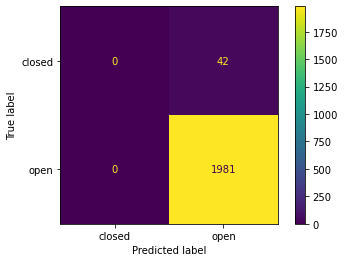

 
training fold: 2
xtrain shape (8090, 600)
time elapsed: 1.3520541191101074
preds unique: ['open']
Fold:2
Accuracy=0.9792284866468842


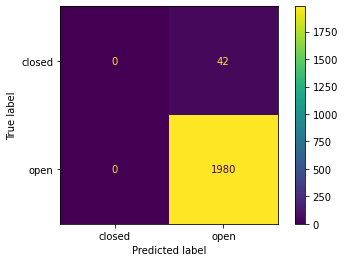

 
training fold: 3
xtrain shape (8090, 600)
time elapsed: 5.567226886749268
preds unique: ['open']
Fold:3
Accuracy=0.9792284866468842


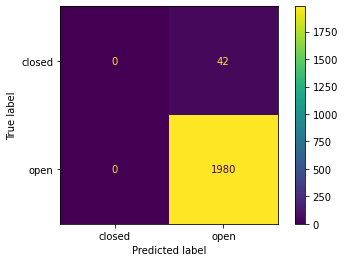

 
training fold: 4
xtrain shape (8090, 600)
time elapsed: 1.3500645160675049
preds unique: ['open']
Fold:4
Accuracy=0.9792284866468842


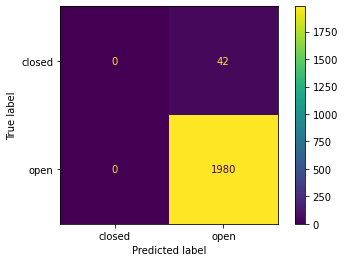

In [22]:
#create sentence embeddings
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def get_vectors(vectors,column):
    """
    vectors: empty array to fill in
    column: dataframe column
    return embedding vestors
    """
    for body in column:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    return vectors   


if __name__=="__main__":
    
    t0=time.time()
    print("creating sentence embedding")
    vector1 =[]
    vector2 =[]
    vectors=[]
    print("the BodyMarkDown column embedding")
    vector1 = get_vectors(vector1,df.BodyMarkdown.values)
    vector1 = np.array(vector1)    
    print("1st column shape",vector1.shape)
    
    print("the Title column embedding")
    vector2 = get_vectors(vector2,df.Title.values)
    vector2 = np.array(vectors2)    
    print("2nd column shape",vector2.shape)
    
    vectors = np.concatenate((vector1,vector2),axis=1)
    
    print("Train column shape",vectors.shape)
    
    # clear up memory
    vector1 =[]
    vector2 =[]
    
    t1=time.time()
    total_time = t1-t0
    print("time embedding",total_time)
    print(" ")           
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print(f"training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        
        xtest=vectors[v_,:]
        ytest =y[v_]
        model=RandomForestClassifier(n_estimators =100, 
                                     max_features='sqrt',random_state=0,
                                     max_depth=10,n_jobs=-1)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")

creating sentence embedding
the BodyMarkDown column embedding
1st column shape (10112, 300)
the Title column embedding
2nd column shape (10112, 300)
Train column shape (10112, 600)
time embedding 8.931170225143433
 
training fold: 0
xtrain shape (8089, 600)
ytrain values:
 (array(['closed', 'open'], dtype=object), array([ 168, 7921]))
time elapsed: 6.524637222290039
preds unique: ['closed' 'open']
Fold:0
Accuracy=0.8255066732575383


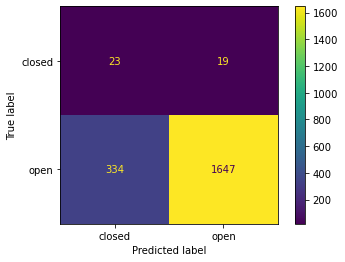

 
training fold: 1
xtrain shape (8089, 600)
ytrain values:
 (array(['closed', 'open'], dtype=object), array([ 168, 7921]))
time elapsed: 2.9567086696624756
preds unique: ['closed' 'open']
Fold:1
Accuracy=0.8121601581809195


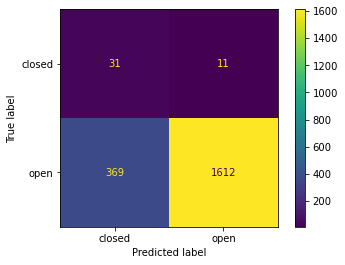

 
training fold: 2
xtrain shape (8090, 600)
ytrain values:
 (array(['closed', 'open'], dtype=object), array([ 168, 7922]))
time elapsed: 2.9718997478485107
preds unique: ['closed' 'open']
Fold:2
Accuracy=0.8343224530168151


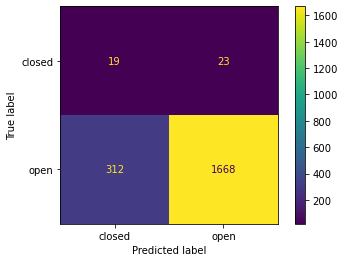

 
training fold: 3
xtrain shape (8090, 600)
ytrain values:
 (array(['closed', 'open'], dtype=object), array([ 168, 7922]))
time elapsed: 3.024646759033203
preds unique: ['closed' 'open']
Fold:3
Accuracy=0.7769535113748763


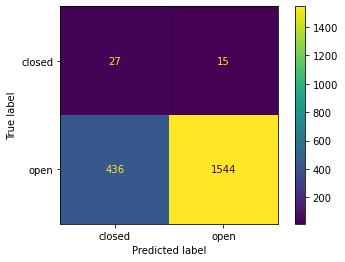

 
training fold: 4
xtrain shape (8090, 600)
ytrain values:
 (array(['closed', 'open'], dtype=object), array([ 168, 7922]))
time elapsed: 3.01284122467041
preds unique: ['closed' 'open']
Fold:4
Accuracy=0.8016815034619189


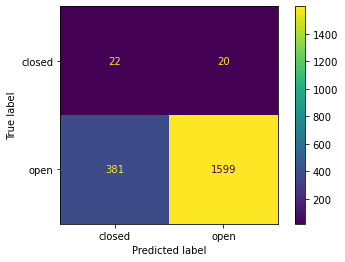

In [26]:
#create sentence embeddings
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedBaggingClassifier

def get_vectors(vectors,column):
    """
    vectors: empty array to fill in
    column: dataframe column
    return embedding vestors
    """
    for body in column:
        vectors.append(
            sentence_to_vec(s= body,
                           embedding_dict = embeddings,
                           stop_words =my_stopwords,
                           tokenizer=tokenize
                           )
        )
    return vectors   


if __name__=="__main__":
    
    t0=time.time()
    print("creating sentence embedding")
    vector1 =[]
    vector2 =[]
    vectors=[]
    print("the BodyMarkDown column embedding")
    vector1 = get_vectors(vector1,df.BodyMarkdown.values)
    vector1 = np.array(vector1)    
    print("1st column shape",vector1.shape)
    
    print("the Title column embedding")
    vector2 = get_vectors(vector2,df.Title.values)
    vector2 = np.array(vectors2)    
    print("2nd column shape",vector2.shape)
    
    vectors = np.concatenate((vector1,vector2),axis=1)
    
    print("Train column shape",vectors.shape)
    
    # clear up memory
    vector1 =[]
    vector2 =[]
    
    t1=time.time()
    total_time = t1-t0
    print("time embedding",total_time)
    print(" ")           
    
    y=df.OpenStatus.values
    # initialize the kfold class
    kf = model_selection.StratifiedKFold(n_splits=5)
    # fill the new kfold column
    for fold_,(t_,v_) in enumerate(kf.split(X=vectors,y=y)):
        print(f"training fold: {fold_}")
        #temp dataframe for train and test
        xtrain=vectors[t_,:]
        ytrain=y[t_]
        print('xtrain shape',xtrain.shape)
        print('ytrain values:\n',np.unique(ytrain, return_counts=True))
        
        xtest=vectors[v_,:]
        ytest =y[v_]
        model=BalancedBaggingClassifier(sampling_strategy=0.9,
                                    n_estimators=1000,
                                    n_jobs=-1,
                                    max_samples=0.05,
                                    warm_start=True)
        t0=time.time()
        #fit the model on training data 
        model.fit(xtrain,ytrain)
        # make predictions
        preds = model.predict(xtest)
        #print(preds.shape)
        #preds1 = [model.classes_[np.argmax(x)] for x in preds]        
        
        t1=time.time()
        total_time = t1-t0
        
        print('time elapsed:', total_time)
        print('preds unique:',np.unique(preds))
        
        # calculate f1 score
        #accuracy = metrics.accuracy_score(test_df.BodyMarkdown, preds)
        accuracy_score = np.sum(preds == ytest) / len(ytest)        #log_loss= metrics.log_loss(train_df.OpenStatus,preds)
        
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy_score}")
        plot_confusion_matrix(model, xtest, ytest)
        plt.show()
        print(" ")